# Automated Spam Filtering

### This is a program to classify phone SMS messages in English as either "spam" or "ham" (=not spam).

#### The language used throughout is Python.

###### Following are the libraries imported :

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import _pickle as cPickle
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

C:\Users\Pawan Sharma\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Pawan Sharma\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Pawan Sharma\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

## Step 1: Analysing the Data

We are using a dataset downloaded from 'https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection'.

This file contains **a collection of more than 5 thousand SMS phone messages (also sometimes called "corpus")** :

In [2]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print (len(messages))

5574


We are using `pandas` llibrary to list the labeled training set separated by tabs.

Using these ham/spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

In [3]:
messages = pandas.read_csv('SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print (messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

We can also view aggregate statistics using `pandas` :

In [4]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Length of the messages :

In [5]:
messages['length'] = messages['message'].map(lambda text: len(text))
print (messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


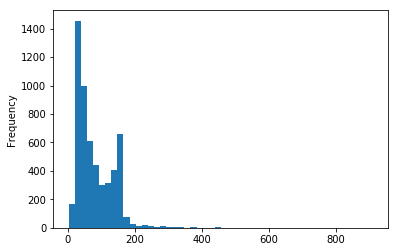

In [6]:
messages.length.plot(bins=50, kind='hist')

In [7]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

#### Message length difference between spam and ham :

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E35507438>,
      dtype=object)

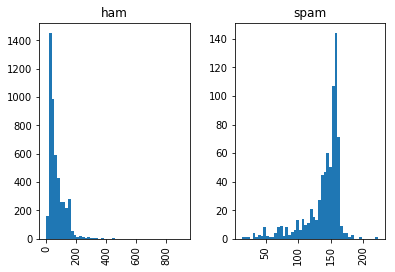

In [8]:
messages.hist(column='length', by='label', bins=50)

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the `bag-of-words` approach, where each unique word in a text will be represented by one number.

As a first step, we will write a function that will split a message into its individual words :

In [9]:
def split_into_tokens(message):
    message = str(message)  # convert bytes into proper unicode
    return TextBlob(message).words

This will divide the message into tokens :

In [10]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

With textblob, we detect `part-of-speech (POS)` tags :

In [11]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

and normalize words into their base form (lemmas) with :

In [12]:
def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [13]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print (len(bow_transformer.vocabulary_))

8857


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [14]:
message4 = messages['message'][3]
print (message4)

U dun say so early hor... U c already then say...


In [15]:
bow4 = bow_transformer.transform([message4])
print (bow4)
print (bow4.shape)

  (0, 1156)	1
  (0, 1895)	1
  (0, 2891)	1
  (0, 2921)	1
  (0, 4015)	1
  (0, 6724)	2
  (0, 7099)	1
  (0, 7685)	1
  (0, 8000)	2
(1, 8857)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [16]:
print (bow_transformer.get_feature_names()[6736])
print (bow_transformer.get_feature_names()[8013])

scenario
ugo


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [17]:
messages_bow = bow_transformer.transform(messages['message'])
print ('sparse matrix shape:', messages_bow.shape)
print ('number of non-zeros:', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8857)
number of non-zeros: 80340
sparsity: 0.16%


In [18]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print (tfidf4)

  (0, 8000)	0.30500390244920195
  (0, 7685)	0.22530830435091123
  (0, 7099)	0.19139747787841085
  (0, 6724)	0.5233907074133691
  (0, 4015)	0.4563719925781256
  (0, 2921)	0.329688073969027
  (0, 2891)	0.30370462627268274
  (0, 1895)	0.24665241656533501
  (0, 1156)	0.27494440163841516


In [19]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print (messages_tfidf.shape)

(5574, 8857)


## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier.

We'll be using scikit-learn here, choosing the `Naive Bayes` classifier :

In [30]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Wall time: 19 ms


Let's try classifying our single random message:

In [31]:
print ('predicted:', spam_detector.predict(tfidf4)[0])
print ('expected:', messages.label[3])

predicted: ham
expected: ham


In [22]:
all_predictions = spam_detector.predict(messages_tfidf)
print (all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [23]:
print (classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



## Step 5: Running experiments

Now we will split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is only used for testing.

In [24]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


The test size is 20% of the entire dataset (1115 messages out of total 5574), and the training is the rest (4459 out of 5574).

In [25]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=1,  # 1 = use all cores = faster
                         )
print (scores)

[0.95749441 0.94170404 0.95067265 0.9529148  0.94394619 0.93946188
 0.96412556 0.9529148  0.9505618  0.9505618 ]


The scores for this set:

In [27]:
print (scores.mean(), scores.std())

0.9504357912978355 0.0069885463380917135


In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [2]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5,n_jobs=1)

NameError: name 'plot_learning_curve' is not defined